
# The *grmpy*  package 
This notebook demonstrates the current capabilities of the *grmpy* package. *grmpy* is an open source package for the programming language python that enables researchers to simulate datasets andestimate parameters using already existing data within the structure of the generalized Roy model. Currently the package serves as a teaching tool for a course on the econometrics of policy evaluation at the University of Bonn. The corresponding lecture materials can be found on [GitHub](https://github.com/HumanCapitalAnalysis/econometrics).  Morover it is thought of as a promotion for the conceptual framework as well as a showcase for basic software engineering practices.

For a more detailed overview on the economic background as well as the installation routine feel free to take a look on the [online documentation](https://grmpy.readthedocs.io/en/develop/).

The notebook itself is divided in three parts. Firstly we provide a basic outline on how to use the package and introduce the core features. Next we will show that the results obtained by the package's estimation process withstand a critical examination by comparing its performance in the presence of essential heterogeneity with several other estimation approaches like Ordinary Least Squares and Instrumental variables. We conclude by conducting a replication of results from   

Carneiro, P., Heckman, J. J., & Vytlacil, E. J. (2011). [Estimating marginal returns to education.](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754)
*American Economic Review, 101*(6), 2754-81.


# The Framework

As mentioned before the package makes use of the normal-linear-in-parameters version generalized Roy model. In addition we assume that the unobservable terms $\{U_1, U_0, V\}$ are normally distributed according to the covariance matrix $\Sigma$. The following set of equations characterize the underlying model:

\begin{align*}
 &\textbf{Potential Outcomes} & & \textbf{Choice}  &\\
 & Y_1 = \beta_1 X + U_{1} &  &D_i = \mathbf{1}\{\Phi(\gamma Z) > u_D\} &\\
 & Y_0 = \beta_0 X + U_{0} &  & \text{with $u_D = \Phi(V)$}  &\\
&&&&\\
&\textbf{Distributional Characteristics}&&&\\
&\{U_{1}, U_{0}, V\} \sim \mathcal{N}\left(0, \Sigma\right)&&\Sigma =  \begin{bmatrix}
    \sigma_1^{2} & \sigma_{1,0} & \sigma_{1,V} \\
    \sigma_{1,0} & \sigma_0^{2} & \sigma_{0,V} \\
    \sigma_{1,V} & \sigma_{0,V} & \sigma_V^{2} \\
  \end{bmatrix}&\\
&&&&\\
& \textbf{Observed Outcome} &&&\\
& Y = D Y_1 + (1-D) Y_0 &&&
\end{align*}


# Preliminaries

The first step consists of some style and import improving settings.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%load_ext autoreload
%autoreload 2

Before we can start with the application examples we have to import several libaries that we rely on during this presentation.

In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import json

import grmpy

In addition we will import some custom functions for plotting several figures of interest as well as some data management purposes. The code is provided in the auxiliary.py file.

In [3]:
from auxiliary import plot_joint_distribution_unobservables
from auxiliary import plot_joint_distribution_potential
from auxiliary import plot_marginal_effects
from auxiliary import process_data
from auxiliary import plot_est_mte
from auxiliary import monte_carlo
from auxiliary import effects

# Part I - Introduction

This part provides some basic information about the general application of the package's core methods. 

## The initialization file

Currently the package has two core features. The first one is the simulation process. It enables users to simulate data sets along a pre-specified parameterization. The data generating process follows the structure of the previously introduced parametric Roy model framework. Therefore users specify their desired parametrization in an initialization file which allows altering any aspects of the model according to their preferences. The ability to estimate parameters on already existing data sets is the second core feature. As before the initialization file is the starting point for the estimation process. 

The initialization file is structured as follows:

* **Simulation**: The simulation section contains information for the estimation process. For instance users are able to change the number of individuals for which the program runs a simulation through setting the agents option to a specific value.


* **Estimation**: Accordingly information regarding the estimation process are stored in the estimation section. Here, users can set the type of optimizer which should be used for running the process as well as the maximum number of iterations that the process is allowed to perform. In addition the flags *dependent* and *indicator* determine which variable of the input data frame is seen as the dependent variable and the treatment indicator variable, respectively.


* **Treated, Untreated, Choice**: These sections are essential for both methods. They contain the parameterization which is used for the simulation process. Additionally the second column indicates the variable labels well as for the simulated data set. This column is also essential for the estimation process because it will only include variables that are pre-specified in a specific section for the following optimization.


* **Dist**: The Dist section determines the distributional characteristics of the unobservable variables. Therefore the section reports the upper triangle of the covariance matrix of $(U_1, U_0,V)$.


* **SCIPY-BFGS/SCIPY-POWELL**: The SCIPY-related sections contain options for the relevant optimization algorithms.

In [4]:
%%file files/tutorial.grmpy.yml
---
SIMULATION:
    agents: 10000
    seed: 2356
    source: data
ESTIMATION:
    file: data.grmpy.txt
    output_file: output/est.grmpy.info
    optimizer: BFGS
    start: auto
    maxiter: 6383
    agents: 165
    dependent: Y
    indicator: D
    comparison: 1
    print_output: 0
TREATED:
    params:
    - 1.0
    - 0.555
    order:
    - const
    - X2
UNTREATED:
    params:
    - 0.5
    - 0.25
    order:
    - const
    - X2
CHOICE:
    params:
    - 0.378
    - -0.39
    order:
    - const
    - X3
DIST:
    params:
    - 0.1
    - 0.0
    - 0.0
    - 0.1
    - 0.0
    - 1.0
VARTYPES:
    const: nonbinary
    X2: nonbinary
    X3: nonbinary
SCIPY-BFGS:
    gtol: 1.0e-05
    eps: 1.4901161193847655e-08
SCIPY-POWELL:
    xtol: 9.147777614048603e-05
    ftol: 9.749582129043358e-05

Overwriting files/tutorial.grmpy.yml


## The Simulation Process

For simulating a dataset we only have to provide the package with the related inititalization file.

In [5]:
data = grmpy.simulate('files/tutorial.grmpy.yml')
data.head(20)

,const,X2,X3,U1,U0,V,Y1,Y0,D,Y
0,1.0,-0.014710,0.023439,0.002676,0.061452,0.767310,0.994512,0.557775,0.0,0.557775
1,1.0,1.941447,-1.375891,0.087087,0.066451,-0.567979,2.164590,1.051813,1.0,2.164590
2,1.0,-0.220668,1.555453,0.078557,0.008140,-0.307828,0.956087,0.452973,1.0,0.956087
3,1.0,0.531899,0.192161,-0.005574,0.055052,-1.129202,1.289630,0.688027,1.0,1.289630
4,1.0,-0.295161,1.663835,-0.111534,0.077755,-0.024787,0.724652,0.503965,0.0,0.503965
5,1.0,2.030613,0.845409,-0.096886,-0.086180,0.117710,2.030104,0.921473,0.0,0.921473
6,1.0,-0.189934,-0.830659,0.019401,-0.045266,-0.037156,0.913988,0.407250,1.0,0.913988
7,1.0,0.590819,1.731056,-0.087072,0.032617,0.719759,1.240833,0.680322,0.0,0.680322
8,1.0,0.790466,1.133287,0.049938,-0.200924,0.749826,1.488647,0.496692,0.0,0.496692
9,1.0,-1.378429,0.020067,0.151613,0.015832,-1.119519,0.386585,0.171225,1.0,0.386585


The simulation process generates an info file that provides additional information about the distribution of outcomes and effects, respectively. Additionally it contains the criterion function value, information about the corresponding marginal treatment effects as well as the paramterization.

In [6]:
!cat "data.grmpy.info"



 Number of Observations 

                            Count

  All                       10000
  Treated                    6391
  Untreated                  3609


 Distribution of Outcomes

                             Mean             Std-Dev.                  25%                  50%                  75%

  All                      0.8196               0.5328               0.4401               0.7467               1.1652
  Treated                  1.0018               0.5580               0.6305               1.0059               1.3721
  Untreated                0.4968               0.2689               0.3218               0.5001               0.6782


 Distribution of Effects

                             Mean             Std-Dev.                  25%                  50%                  75%

  All                      0.4998               0.3340               0.2739               0.4974               0.7208
  Treated                  0.5007               0.3354              

The generated data set is specififed so that the treatment selection process is not affected by essential heterogeneity. Therefore the conventional effects are nearly identical. 

ATE: 0.49983004856551627
TT:  0.500730693488769
TUT: 0.4982351409167191 



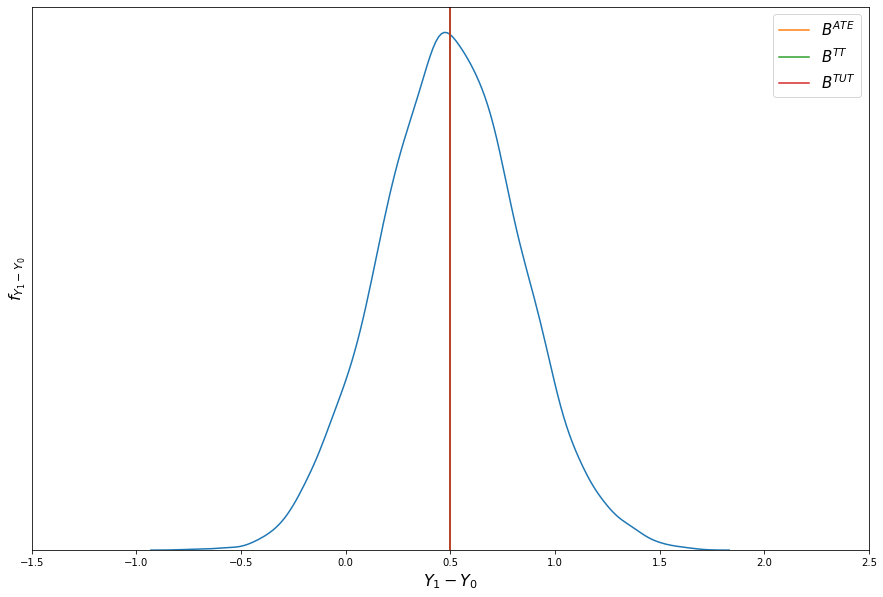

In [7]:
effects(data)

### Essential Heterogeneity
For providing an example on how essential heterogeneity biases the results obtained by naive comparison between treated and untreated individuals, we alter the initialization file. Specifically we will introduce correlation between the unobservable terms. This leads to the situation where individuals select into treatment based on unobservable gains. Therefore the treatment decision $D$ is no longer independent from the outcomes $Y_1$ and $Y_0$.

\begin{align}
Y_1,Y_0\;\; {\perp\!\!\!\!\!\!\diagup\!\!\!\!\!\!\!\perp} \;\; D
\end{align}

Unlike in the absence of essential heterogeneity individuals who select themselves into treatment differ from
individuals who do not with respect to their unobservable characteristics. From this follows that

\begin{align}
B^{ATE} \neq B^{TT} \neq B^{TUT}
\end{align}

In [8]:
%%file files/tutorial_eh.grmpy.yml
---
SIMULATION:
    seed: 2356
    agents: 10000
    source: data_eh
ESTIMATION:
    file: data_eh.grmpy.txt
    start: auto
    agents: 165
    optimizer: BFGS
    maxiter: 6383
    dependent: Y
    indicator: D
    output_file: output/est.grmpy.info
    comparison: 1
    print_output: 0

TREATED:
    params:
    - 1.0
    - 0.555
    order:
    - const
    - X2
UNTREATED:
    params:
    - 0.5
    - 0.25
    order:
    - const
    - X2
CHOICE:
    params:
    - 0.378
    - -0.39
    order:
    - const
    - X3
DIST:
    params:
    - 0.1
    - 0.0
    - 0.0524
    - 0.1
    - -0.0216
    - 1.0
VARTYPES:
    const: nonbinary
    X2: nonbinary
    X3: nonbinary
SCIPY-BFGS:
    gtol: 1.0e-05
    eps: 1.4901161193847655e-08
SCIPY-POWELL:
    xtol: 9.147777614048603e-05
    ftol: 9.749582129043358e-05

Overwriting files/tutorial_eh.grmpy.yml


In [9]:
data_eh = grmpy.simulate('files/tutorial_eh.grmpy.yml')
data_eh.head(20)

,const,X2,X3,U1,U0,V,Y1,Y0,D,Y
0,1.0,-0.014710,0.023439,-0.015029,0.072663,-0.767427,0.976807,0.568986,1.0,0.976807
1,1.0,1.941447,-1.375891,0.121409,0.021829,0.563892,2.198912,1.007191,1.0,2.198912
2,1.0,-0.220668,1.555453,0.078986,-0.023754,0.304143,0.956515,0.421079,0.0,0.421079
3,1.0,0.531899,0.192161,0.076321,0.028085,1.129450,1.371525,0.661060,0.0,0.661060
4,1.0,-0.295161,1.663835,-0.053739,0.106255,0.030013,0.782446,0.532464,0.0,0.532464
5,1.0,2.030613,0.845409,-0.112613,-0.046794,-0.113168,2.014377,0.960859,1.0,2.014377
6,1.0,-0.189934,-0.830659,-0.000561,-0.048730,0.036247,0.894026,0.403786,1.0,0.894026
7,1.0,0.590819,1.731056,-0.091649,0.073059,-0.715671,1.236255,0.720764,1.0,1.236255
8,1.0,0.790466,1.133287,-0.078217,-0.185083,-0.752158,1.360492,0.512533,1.0,1.360492
9,1.0,-1.378429,0.020067,0.180205,-0.057158,1.112402,0.415177,0.098234,0.0,0.098234


In [10]:
!cat "data_eh.grmpy.info"



 Number of Observations 

                            Count

  All                       10000
  Treated                    6384
  Untreated                  3616


 Distribution of Outcomes

                             Mean             Std-Dev.                  25%                  50%                  75%

  All                      0.7945               0.5279               0.4237               0.7200               1.1301
  Treated                  0.9721               0.5557               0.6012               0.9698               1.3457
  Untreated                0.4809               0.2674               0.3072               0.4807               0.6615


 Distribution of Effects

                             Mean             Std-Dev.                  25%                  50%                  75%

  All                      0.4987               0.3328               0.2705               0.5020               0.7210
  Treated                  0.4607               0.3279              

ATE: 0.4987192962464583
TT:  0.46070333176413386
TUT: 0.5658359769033056 



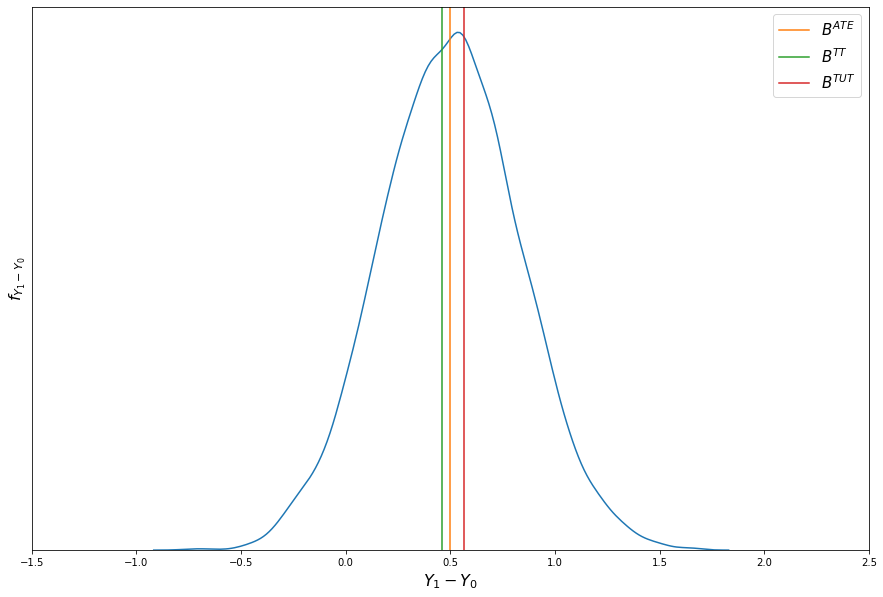

In [11]:
effects(data_eh)

Next we illustrate how essential heterogeneity is refelected in the joint distribution of the error term. For that purpose we created two figures that show the relationship between $U_1$ and $V$ for both data sets which we simulated before.

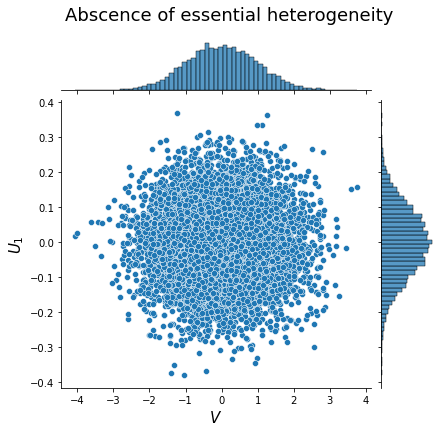

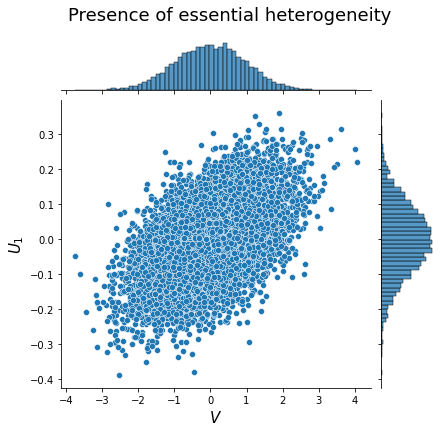

In [12]:
plot_joint_distribution_unobservables(data, data_eh)

Simulating data sets enables us to explore more facets of the impact of essential heterogeneity on the marginal effect of treatment. The marginal effect of treatment, henceforth denoted as $B^{MTE}$ is defined as the effect of treatment for individuals that are indifferent between taking the treatment or not along the distribution of the unobservable variable $V$. This means that instead of assigning explicitly one value as the effect of treatment the $B^{MTE}$ provides a continuum of effects along the distribution of the unobservable $V$. More formally:

\begin{align*}
B^{MTE} = E[Y_1-Y_0|X=x, U_D = u_D] \\
\end{align*}

In the abscence of essential heterogeneity $B^{MTE}$ provides a constant value over the whole distribution of $V$. This implies that the individual's decision for treatment participation is independent of their unobservable benefits so that each individual on the margin faces the same average benefit of treatment. This can be seen in the figure below. The flat line captures the $B^{MTE}$ for the simulated data without essential heterogeneity, wheras the increasing cure illustrates the marginal effect for the one that is affected by essential heterogeneity.

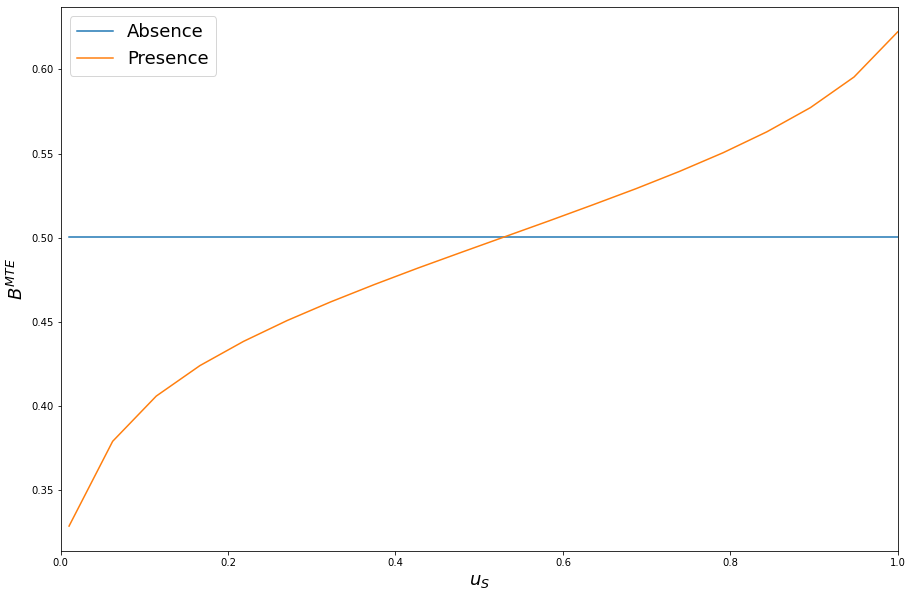

In [13]:
plot_marginal_effects('data.grmpy.info', 'data_eh.grmpy.info')

Using simulated data allows us to tackle issues and explore additional objects of interest for which we are not able to obtain reliable information if we use empirical data sets. For instance we are able to construct the joint distribution of potential outcomes from the previously simulated data sets because our simulated data allows us to evade the evaluation problem. This means that we have information about the whole space of potential outcomes for each individual. 

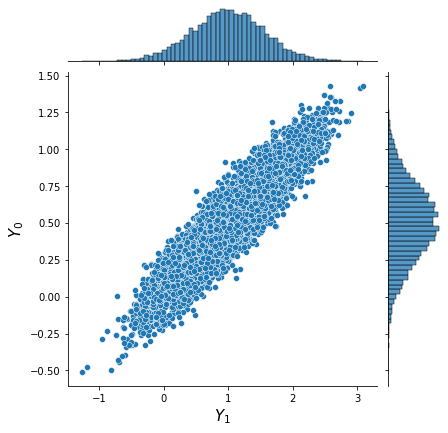

In [14]:
plot_joint_distribution_potential(data_eh)

## The Estimation Process

grmpy enables users to estimate parameters on data sets. Executing an estimation is simple. Just setup your estimation specifications in the initialization file and provide the estimation process with the resulting initialization file.

In [15]:
rslt = grmpy.fit('files/tutorial_eh.grmpy.yml')

The estimation process returns a detailed overview of the results via an output file

In [16]:
!cat output/est.grmpy.info

                              Optimization Results
Dep. Variable:                    Y     Optimizer:                          BFGS
Choice Var:                       D     No. Evaluations:                      30
Date:              Wed, 14 Apr 2021     Success:                               1
Time:                      20:00:21     Status:                                0
Observations:                 10000     Message:         Optimization terminated
Start Values:                  auto                                successfully.
                                        Criterion Func:                         
                                             Start:                      -0.1862
                                             Finish:                     -0.3230
                        coef   std err         t     P>|t|     [0.025     0.975]
--------------------------------------------------------------------------------
TREATED       

const                 0.9981     0.003   3

## Software Engineering Practices


# Part II - Monte Carlo Simulation

For illustrating the advantages of grmpy's estimation process in the presence of essential heterogeneity we conduct a Monte Carlo exercise. As before the starting point of the exericise is an initialization file over which we iterate several times during the process. The distributional characteristics are such that the unobservable variables are distributed according to the following covariance matrix

\begin{align}
\Sigma =  \begin{bmatrix}
    0.01 & 0 & \frac{\rho_{1,V}}{0.1}  \\
    0 & 0.01 & 0 \\
    \frac{\rho_{1,V}}{0.1}  & 0 & 1 \\
  \end{bmatrix}
\end{align}

During each step of the iteration we increase the correlation between $U_1$ and $V$. We will start from a value of $\rho_1 =0.0$ and end at $\rho_1 = 0.99$. This increase is equivalent to the observation of incremental reverse selection behavior, because individuals with a low value of $V$ which are most likely to select into treatment have on average a lower value of $U_1$ than individuals that have larger values of $V$. in addition we estimate the average effect of treatment during each step. For this purpose we use the grmpy estimation process, an ordinary least squares regression and an instrumental variables approach as well as a naive comparison of outputs between treated and untreated individuals.



### The Initialization file

In [17]:
%%file files/mc.grmpy.yml
---
SIMULATION:
    seed: 5133
    agents: 10000
    source: mc
ESTIMATION:
    file: mc.grmpy.txt
    start: auto
    agents: 165
    optimizer: BFGS
    maxiter: 6383
    dependent: wage
    indicator: state
    output_file: mc_rslt.grmpy.info
    comparison: 0
    print_output: 0

TREATED:
    params:
    - 0.99
    - 0.555
    - -0.555
    - 0.755
    - 0.155
    order:
    - const
    - X2
    - X3
    - X4
    - X5
UNTREATED:
    params:
    - 0.5
    - 0.255
    - -0.255
    - 0.1768
    - 0.0987
    
    order:
    - const
    - X2
    - X3
    - X4
    - X5
CHOICE:
    params:
    - 0.28
    - -0.39
    - 0.59
    - -0.89
    - -0.73

    order:
    - const
    - X6
    - X7
    - X8
    - X9

DIST:
    params:
    - 0.2
    - 0.0
    - 0.0
    - 0.2
    - 0.0
    - 1.0
VARTYPES:
    const: nonbinary
    X2: nonbinary
    X3: nonbinary
    X4: nonbinary
    X5: nonbinary
    X6: nonbinary
    X7: nonbinary
    X8: nonbinary
    X9: nonbinary
SCIPY-BFGS:
    gtol: 1.0e-05
    eps: 1.4901161193847655e-08
SCIPY-POWELL:
    xtol: 9.147777614048603e-05
    ftol: 9.749582129043358e-05

Overwriting files/mc.grmpy.yml


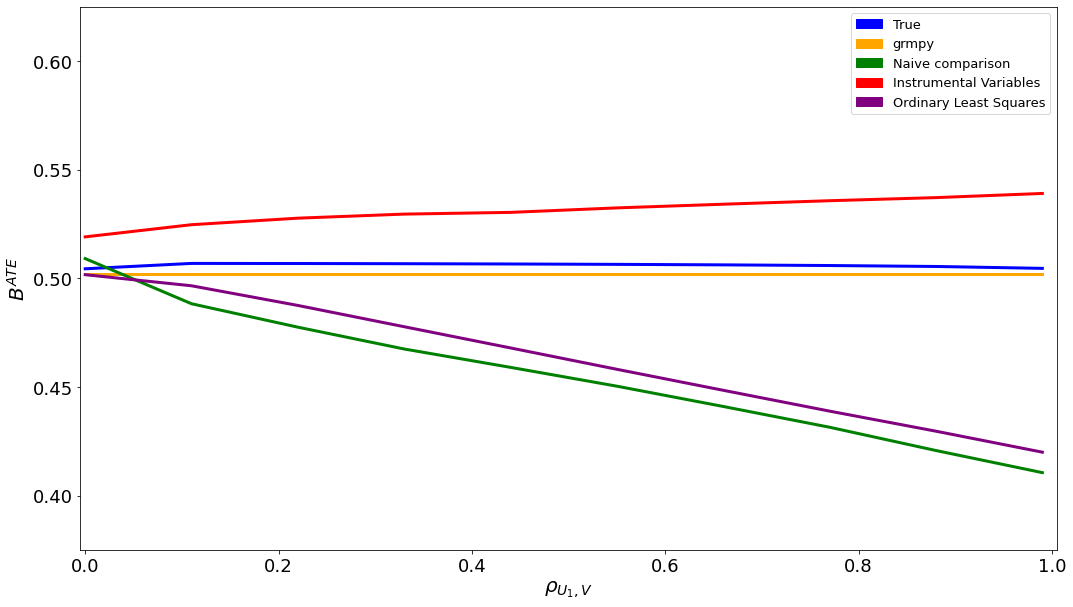

In [18]:
grmpy.simulate('files/mc.grmpy.yml')
monte_carlo('files/mc.grmpy.yml', 10)

As can be seen from the figure, the OLS estimator and the naive comparison of outcomes between the treated and untreated subpopulation underestimate the effect significantly. The stronger the correlation between the unobservable variables the more or less stronger bias. Moreover the IV estimates become upward biased as soon the impact of essential heterogeneity increases. Conversely to the other estimation approaches the grmpy estimate of the average effect is close to the true value even if the unobservables are almost perfectly correlated.

# Part III - Replication Carneiro & Heckman & Vytlacil 2011

Since the current version of grmpy is not capable of estimating non-parametric versions of the Roy models, our
replication of Carneiro et al. (2011) will focus on reproducing the results for the marginal treatment effect of the parametric selection model. Due to reasons of privacy regarding local variables, we are not able to merge the data provided by the authors so that they fully coincide with the original data set. Therefore our replication setup makes use of a mock data set. For this purpose we randomly merge the individual specific data with the local characteristics.

In [19]:
basic = pd.read_stata('data/basicvariables.dta')
local = pd.read_stata('data/localvariables.dta') 
df = pd.concat([basic, local], axis = 1)
process_data(df,'data/aer-replication-mock')

In the next step we have to create a inititalization file that fully coincides with the setup by Carneiro et. al. (2011). Therefore we use the information that the authors provide in their appendix to create the following init file:

In [20]:
%%file files/replication.grmpy.yml
---
SIMULATION:
    seed: 5062
    agents: 991
    source: 8EF73AA0
ESTIMATION:
    file: data/aer-replication-mock.pkl
    start: auto
    agents: 1000
    optimizer: BFGS
    maxiter: 80000
    dependent: wage
    indicator: state
    output_file: replication.grmpy.info
    comparison: 0
    print_output: True

TREATED:
    params:
    - 1.0
    order:
    - const
    - exp
    - expsq
    - lwage5
    - lurate
    - cafqt
    - cafqtsq
    - mhgc
    - mhgcsq
    - numsibs
    - numsibssq
    - urban14
    - lavlocwage17
    - lavlocwage17sq
    - avurate
    - avuratesq
    - d57
    - d58
    - d59
    - d60
    - d61
    - d62
    - d63
UNTREATED:
    params:
    - 1.0
    order:
    - const
    - exp
    - expsq
    - lwage5
    - lurate
    - cafqt
    - cafqtsq
    - mhgc
    - mhgcsq
    - numsibs
    - numsibssq
    - urban14
    - lavlocwage17
    - lavlocwage17sq
    - avurate
    - avuratesq
    - d57
    - d58
    - d59
    - d60
    - d61
    - d62
    - d63
CHOICE:
    params:
    - 1.0
    order:
    - const
    - cafqt
    - cafqtsq
    - mhgc
    - mhgcsq
    - numsibs
    - numsibssq
    - urban14
    - lavlocwage17
    - lavlocwage17sq
    - avurate
    - avuratesq
    - d57
    - d58
    - d59
    - d60
    - d61
    - d62
    - d63
    - lwage5_17numsibs
    - lwage5_17mhgc
    - lwage5_17cafqt
    - lwage5_17
    - lurate_17
    - lurate_17numsibs
    - lurate_17mhgc
    - lurate_17cafqt
    - tuit4c
    - tuit4cnumsibs
    - tuit4cmhgc
    - tuit4ccafqt
    - pub4
    - pub4numsibs
    - pub4mhgc
    - pub4cafqt
DIST:
    params:
    - 0.1
    - 0.0
    - 0.0
    - 0.1
    - 0.0
    - 1.0
VARTYPES:
    const: nonbinary
SCIPY-BFGS:
    gtol: 1.0e-05
    eps: 1.4901161193847656e-08
SCIPY-POWELL:
    xtol: 0.0001
    ftol: 0.0001

Overwriting files/replication.grmpy.yml


We then conduct an estimation based on the initialization file.

In [21]:
rslt = grmpy.fit('files/replication.grmpy.yml')

                              Optimization Results
Dep. Variable:                 wage     Optimizer:                          BFGS
Choice Var:                   state     No. Evaluations:                     289
Date:              Wed, 14 Apr 2021     Success:                               1
Time:                      20:00:48     Status:                                0
Observations:                  1747     Message:         Optimization terminated
Start Values:                  auto                                successfully.
                                        Criterion Func:                         
                                             Start:                      +1.2580
                                             Finish:                     +1.0666
                        coef   std err         t     P>|t|     [0.025     0.975]
--------------------------------------------------------------------------------
TREATED       

const               -35.0684    39.324    

Next we plot the MTE based on our estimation results. As shown in the figure below the results are really close to the original results. The deviation seems to be negligible because we use a mock dataset.

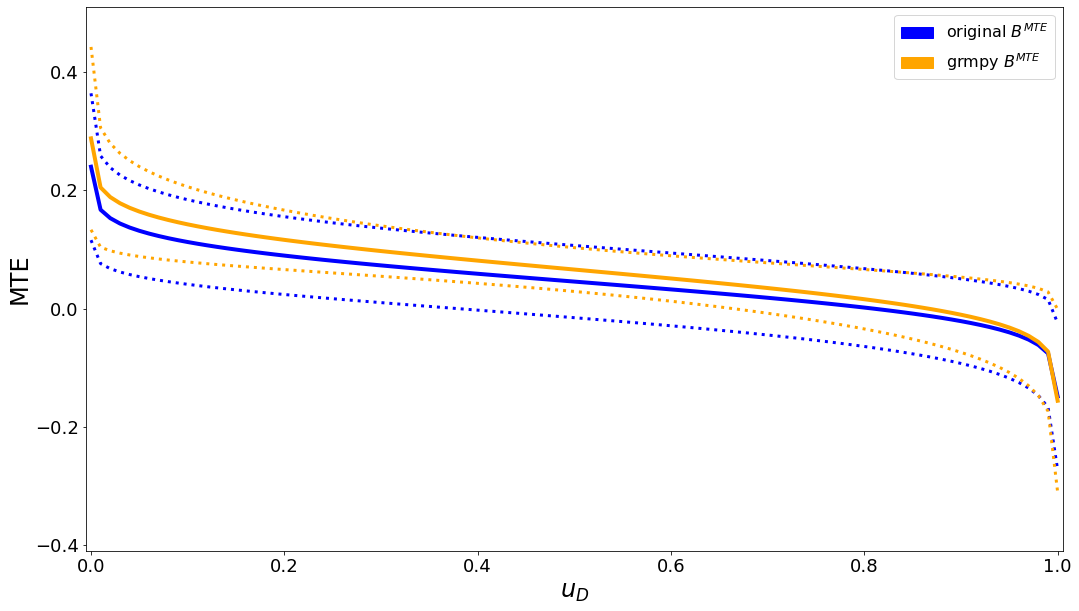

In [22]:
mte = plot_est_mte(rslt, 'files/replication.grmpy.yml')


For a detailed overview on the theoretical economic background, more application examples as well as contact informations see the [online documentation](https://grmpy.readthedocs.io/en/latest/index.html). In addition, the most current code is available on [GitHub](https://github.com/OpenSourceEconomics/grmpy).


